This notebook shows the training of various decision-tree based regression models with several versions of the dataset without any normalization or standardization of the features.

## Import libraries

In [1]:
from utils.sql_utils import extract_data_from_sql_db

import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('bmh')

import numpy as np
import pandas as pd

from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error

# Decision tree-based algoritms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Load data

In [3]:
filter_params = {
    'year': 2021,
    'month': 1,
    'property_type': 'apartment',
    'operation': 'rent'
}

df = extract_data_from_sql_db(**filter_params)

# Create new variables
df['balcony_area'] = df['total_area_m2'] - df['covered_area_m2']
df['has_balcony_yn'] = np.where(df['balcony_area']==0, 0, 1)

## Clean data

In [4]:
comunas_list = [
    'Santiago',
    'Las Condes',
    'Providencia',
    'Ñuñoa',
    'Vitacura',
    'Estación Central',
    'San Miguel',
    'Independencia',
    'Lo Barnechea',
    'Macul',
    'La Florida',
    'Recoleta',
    'Quinta Normal',
    'La Cisterna',
    'San Joaquín',
    'La Reina',
    'Huechuraba'
]

In [5]:
neighborhoods_list = [
    # Huechuraba
    'Pedro Fontova',
    'Bosques De La Pirámide',
    'Ciudad Empresarial',
    'Huechuraba',
    # La Reina
    'Blest Gana',
    'La Reina',
    'Metro Príncipe De Gales - Country Club',
    'Metro Simón Bolivar',
    'Carlos Ossandón',
    # San Joaquín
    'Rodrigo De Araya',
    'San Joaquín',
    'Carlos Valdovinos',
    'Metro San Joaquín',
    # La Cisterna
    'Lo Ovalle',
    'Metro La Cisterna',
    'La Cisterna',
    'El Parrón',
    # Quinta Normal
    'Gruta De Lourdes',
    'Quinta Normal',
    'Parque Padre Renato Poblete',
    'Blanqueado',
    'Salvador Gutiérrez',
    # Recoleta
    'Cerro Blanco',
    'Bellavista',
    'Recoleta',
    'Patronato',
    'Cementerios',
    # La Florida
    'Plaza Vespucio',
    'La Florida',
    'Vicente Valdés',
    'Metro Mirador',
    'La Florida Alto',
    'Rojas Magallanes',
    # Macul
    'Macul',
    'Metro Camino Agrícola',
    'Metro Las Torres',
    'Villa Macul',
    'Las Dalias',
    'Santa Julia De Macul',
    'Escuela Agrícola',
    'Metro Carlos Valdovinos',
    'Metro Macul',
    'Metro Quilín',
    'Metro Los Presidentes',
    # Lo Barnechea
    'La Dehesa',
    'Lo Barnechea',
    'Puente Nuevo',
    'Los Trapenses',
    'El Huinganal',
    'Plaza San Enrique',
    'Valle Escondido',
    # Independencia
    'Hospitales',
    'Plaza Chacabuco',
    'Independencia',
    'Juan Antonio Ríos',
    'Metro Cal Y Canto',
    # San Miguel
    'Lo Vial',
    'Ciudad Del Niño',
    'El Llano',
#     'San Miguel',
    # Estación Central
    'San Alberto Hurtado',
    'Metro Ecuador',
    'Metro Las Rejas',
    'Universidad De Santiago',
    # Vitacura
    'Parque Bicentenario',
    'Pío Xi',
    'Tabancura',
#     'Vitacura',
    'Jardín Del Este',
    'La Llavería',
    'Juan Xxiii',
    'Santa María De Manquehue',
    'Estadio Manquehue',
    'Borde Río - Casa Piedra',
    'Lo Curro',
    'Estadio Croata',
    'Nuestra Señora Del Rosario',
    'Villa El Dorado',
    # Ñuñoa
    'Metro Irarrázaval',
    'Plaza Ñuñoa',
    'Metro Monseñor Eyzaguirre',
    'Metro Ñuñoa',
    'Estadio Nacional',
    'Plaza Egaña',
    'Parque Juan Xxiii',
    'Parque San Eugenio - Metro Ñuble',
    'Diagonal Oriente',
    'Metro Simón Bolivar',
    'Juan Gómez Millas',
    'Villa Frei',
    'Diego De Almagro',
    'Parque Botánico',
    'Amapolas',
    # Providencia
    'Los Leones',
    'Las Lilas',
    'Pedro De Valdivia',
    'Manuel Montt',
    'Metro Tobalaba - Mall Costanera',
    'Salvador',
    'Inés De Suárez',
    'Barrio Italia',
    'Campus Oriente',
    'Plaza Italia',
    'Metro Bilbao',
    'Pedro De Valdivia Norte',
    'Bellavista',
    # Las Condes
    'Barrio El Golf',
    'Metro Escuela Militar',
    'Metro Manquehue - Apumanque',
    'Parque Arauco',
    'Centro Financiero',
    'Nueva Las Condes',
    'Metro Hernando De Magallanes',
    'Sebastián Elcano',
    'Alto Las Condes',
    'Vaticano',
    'Rotonda Atenas',
    'Mall Sport',
    'San Carlos De Apoquindo',
    'Los Dominicos',
    'Estoril',
    'San Damián',
    'Parque Padre Alberto Hurtado',
    'Colón Oriente - Vital Apoquindo',
    # Santiago
    'Centro Histórico De Santiago',
    'Santa Isabel',
    'Bulnes',
    'San Diego',
    'Parque Almagro',
    'Bogotá - Sierra Bella',
    "Parque O'Higgins",
    'Ejército - Toesca',
    'Barrio Diez De Julio',
    'Barrio Yungay',
    'Barrio Brasil',
    'Barrio República',
    'Barrio Lastarria',
    'Franklin - Biobío',
    'Parque Los Reyes',
    'Barrio San Borja'
]

In [6]:
to_delete = df[
    (df['comuna'].isin(comunas_list)==False) |
    (df['neighborhood'].isin(neighborhoods_list)==False) |
    (df['balcony_area'] > 100) |
    (df['bathrooms'] > df['bedrooms'] + 1) |
    (df['bathrooms'] < df['bedrooms'] - 2) |
    ((df['bedrooms']==1) & (df['price'] > 2000000)) |
    ((df['bedrooms']==2) & (df['price'] > 3000000)) |
    ((df['comuna']=='Huechuraba') & (df['price'] >= 1000000)) |
    ((df['comuna']=='La Reina') & (df['price'] >= 1000000)) |
    ((df['comuna']=='San Joaquín') & (df['price'] >= 500000)) |
    ((df['comuna']=='La Cisterna') & (df['price'] >= 500000)) |
    ((df['comuna']=='Quinta Normal') & (df['price'] >= 500000)) |
    ((df['comuna']=='Recoleta') & (df['price'] >= 700000)) |
    ((df['comuna']=='La Florida') & (df['price'] >= 600000)) |
    ((df['comuna']=='Macul') & (df['price'] >= 600000)) |
    ((df['comuna']=='Independencia') & (df['price'] >= 500000)) |
    ((df['comuna']=='San Miguel') & (df['price'] >= 700000)) |
    ((df['comuna']=='Estación Central') & (df['price'] >= 500000)) |
    ((df['comuna']=='Ñuñoa') & (df['price'] >= 1000000)) |
    ((df['comuna']=='Providencia') & (df['price'] >= 1500000)) |
    ((df['comuna']=='Santiago') & (df['price'] >= 1000000))
].index.tolist()

df.drop(to_delete, axis=0, inplace=True)

In [7]:
# Delete rows of comuna-bedroom categories which have less than 5 properties
rows_to_delete = []
for cat in df['bedrooms'].unique():
    data = df[df['bedrooms']==cat]
    count_series = data['comuna'].value_counts()
    comunas_to_delete = count_series[count_series < 5].index.tolist()
    idx_list = data[data['comuna'].isin(comunas_to_delete)].index.tolist()
    rows_to_delete.extend(idx_list)
    
df.drop(rows_to_delete, axis=0, inplace=True)

In [8]:
df.head()

,price,bedrooms,bathrooms,covered_area_m2,total_area_m2,comuna,neighborhood,balcony_area,has_balcony_yn
0,523546,1,1,50,60,Las Condes,Barrio El Golf,10,1
1,550000,1,1,30,30,Las Condes,Barrio El Golf,0,0
2,400000,1,1,37,37,Las Condes,Barrio El Golf,0,0
3,465375,1,1,48,51,Las Condes,Barrio El Golf,3,1
4,450000,1,1,45,45,Las Condes,Barrio El Golf,0,0


## Check cleaned data

In [9]:
df[['price', 'covered_area_m2', 'total_area_m2']].describe().astype('int')

,price,covered_area_m2,total_area_m2
count,17796,17796,17796
mean,586464,68,74
std,470564,48,55
min,175000,16,16
25%,310000,38,40
50%,420000,50,54
75%,670000,80,87
max,4072028,500,600


In [10]:
df['comuna'] = df['comuna'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17796 entries, 0 to 18190
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   price            17796 non-null  int64   
 1   bedrooms         17796 non-null  int64   
 2   bathrooms        17796 non-null  int64   
 3   covered_area_m2  17796 non-null  int64   
 4   total_area_m2    17796 non-null  int64   
 5   comuna           17796 non-null  category
 6   neighborhood     17796 non-null  category
 7   balcony_area     17796 non-null  int64   
 8   has_balcony_yn   17796 non-null  int32   
dtypes: category(2), int32(1), int64(6)
memory usage: 1.1 MB


## Train machine learning models

In [12]:
TRAIN_SIZE = 0.80

features_list = [
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'comuna', 'neighborhood'], # dataset 01
    ['bedrooms', 'bathrooms', 'total_area_m2', 'comuna', 'neighborhood'], # dataset 02
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'total_area_m2', 'comuna', 'neighborhood'], # dataset 03
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'], # dataset 04
    ['bedrooms', 'bathrooms', 'total_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'], # dataset 05
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'balcony_area', 'comuna', 'neighborhood'], # dataset 06
    ['bedrooms', 'bathrooms', 'total_area_m2', 'balcony_area', 'comuna', 'neighborhood'] # dataset 07
]

data_dict = dict()

for idx, features in enumerate(features_list):
    # Define features and target
    X = df[features]
    y = df['price']
    
    # Get dummy variables
    X = pd.get_dummies(X)
    
    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=TRAIN_SIZE, 
                                                        random_state=21)
    
    seed_dict = dict()
    
    for num in range(10):
        SEED = num
    
        ml_models = {
            'DecisionTree': DecisionTreeRegressor(random_state=SEED),
            'RandomForest': RandomForestRegressor(random_state=SEED, 
                                                  n_jobs=-1),
            'GradientBoosting': GradientBoostingRegressor(random_state=SEED),
            'Bagging': BaggingRegressor(random_state=SEED, 
                                        n_jobs=-1),
            'ExtraTrees': ExtraTreesRegressor(random_state=SEED, 
                                              n_jobs=-1),
            'HistGradientBoosting': HistGradientBoostingRegressor(random_state=SEED),
            'XGBoost': XGBRegressor(use_label_encoder=False, 
                                    eval_metric='mae', 
                                    objective='reg:squarederror', 
                                    random_state=SEED, 
                                    n_jobs=-1),
            'LightGBM': LGBMRegressor(random_state=SEED, 
                                      n_jobs=-1),
            'CatBoost': CatBoostRegressor(random_seed=SEED, 
                                          silent=True)
        }
    
        # Train models
        scores = []
        for key in ml_models:
            estimator = ml_models[key]
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            score = int(median_absolute_error(y_test, y_pred))
            scores.append(score)
    
        seed_dict['seed_{}'.format(num)] = scores
    
    data_dict['dataset_0{}'.format(idx + 1)] = seed_dict

In [13]:
nested_dict = {
    (i,j): data_dict[i][j] 
    for i in data_dict.keys() 
    for j in data_dict[i].keys()
}

mux = pd.MultiIndex.from_tuples(nested_dict.keys())
results = pd.DataFrame(list(nested_dict.values()), index=mux, columns=ml_models.keys())
results

DecisionTree  RandomForest  GradientBoosting  Bagging  \
dataset_01 seed_0         43877         40598             46351    41000   
           seed_1         43876         40662             46351    42000   
           seed_2         44500         41289             46351    41775   
           seed_3         44190         40575             46351    41500   
           seed_4         43895         40819             46351    40879   
...                         ...           ...               ...      ...   
dataset_07 seed_5         41306         39038             44927    39247   
           seed_6         41464         39005             44927    39751   
           seed_7         40916         39413             44927    40244   
           seed_8         42018         38749             44927    39928   
           seed_9         40387         38999             44927    40373   

                   ExtraTrees  HistGradientBoosting  XGBoost  LightGBM  \
dataset_01 seed_0       40717                 43619    46765     41915   
           seed_1       40308                 42091    46765     41915   
           seed_2       40994                 42366    46765     41915   
           seed_3       40816                 42907    46765     41915   
           seed_4       40716                 42081    46765     41915   
...                       ...                   ...      ...       ...   
dataset_07 seed_5       40000                 41087    44847     39724   
           seed_6       40000                 41130    44847     39724   
           seed_7       40000                 41114    44847     39724   
           seed_8       40000                 43915    44847     39724   
           seed_9       40000                 40769    44847     39724   

                   CatBoost  
dataset_01 seed_0     40833  
           seed_1     41397  
           seed_2     40863  
           seed_3     41198  
           seed_4     40577  
...                     ...  
dataset_07 seed_5     39181  
           seed_6     39784  
           seed_7     39179  
           seed_8     39671  
           seed_9     39369  

[70 rows x 9 columns]

## Analyze results

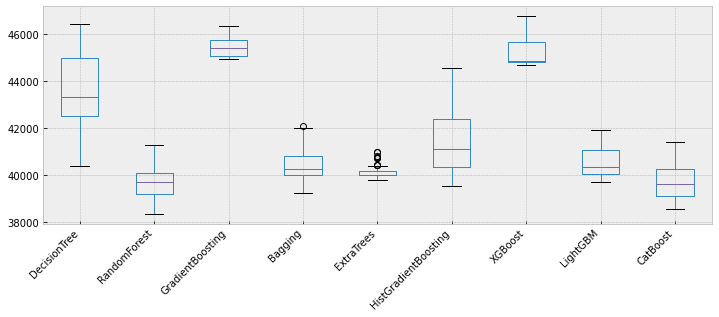

RandomForest            39663.528571
CatBoost                39728.685714
ExtraTrees              40131.600000
Bagging                 40417.157143
LightGBM                40598.000000
HistGradientBoosting    41471.428571
DecisionTree            43539.242857
XGBoost                 45256.285714
GradientBoosting        45500.142857
dtype: float64


In [14]:
plt.figure(figsize=(12,4))
results.boxplot()
plt.xticks(rotation=45, ha='right')
plt.show()

print(results.mean().sort_values())

In [15]:
# Minimum values for each model
print(results.min().sort_values())

RandomForest            38348
CatBoost                38564
Bagging                 39247
HistGradientBoosting    39552
LightGBM                39724
ExtraTrees              39806
DecisionTree            40387
XGBoost                 44687
GradientBoosting        44927
dtype: int64


### Measure difference between average score of best performing algorithms

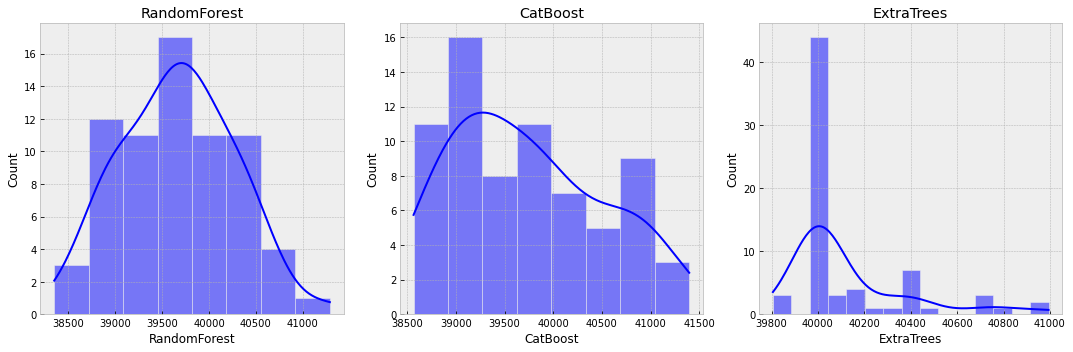

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
best_models = results.mean().sort_values().index.tolist()[:3]

for ax, name in zip(axes.flatten(), best_models):
    sb.histplot(data=results[name], kde=True, ax=ax)
    ax.set_title(name)
    
    fig.tight_layout()

In [17]:
a = results['RandomForest'].values
b = results['CatBoost'].values

print(stats.ttest_rel(a, b))
print(stats.wilcoxon(a, b))

Ttest_relResult(statistic=-0.8440506227950222, pvalue=0.4015579952997743)
WilcoxonResult(statistic=1066.0, pvalue=0.3016417705095874)


In [18]:
a = results['RandomForest'].values
b = results['ExtraTrees'].values

print(stats.ttest_rel(a, b))
print(stats.wilcoxon(a, b))

Ttest_relResult(statistic=-8.292445107423564, pvalue=5.833482418525848e-12)
WilcoxonResult(statistic=209.0, pvalue=1.4642159118438566e-09)


In [19]:
a = results['CatBoost'].values
b = results['ExtraTrees'].values

print(stats.ttest_rel(a, b))
print(stats.wilcoxon(a, b))

Ttest_relResult(statistic=-5.152810172942229, pvalue=2.3250899693318894e-06)
WilcoxonResult(statistic=490.0, pvalue=1.0638237206104543e-05)


#### We can assume that there is no difference in the average score between the two best performing algorithms which are Random Forest and CatBoost. Also we can assume that both algorithms perform better than the third best performing algorithm (ExtraTrees).

### Calculate score means by dataset

In [26]:
idx_list, dataset_means = [], []

for i in range(7):
    dataset_num = 'dataset_0{}'.format(i + 1)
    idx_list.append(dataset_num)
    score_mean = results.loc[(dataset_num), :].mean().mean()
    dataset_means.append(score_mean)
    
print(round(pd.Series(dataset_means, index=idx_list).sort_values(), 0))

dataset_07    41165.0
dataset_02    41403.0
dataset_05    41620.0
dataset_06    41679.0
dataset_03    41810.0
dataset_04    42256.0
dataset_01    42750.0
dtype: float64


### Experiment with Random Forest

In [30]:
TRAIN_SIZE = 0.80

features_list = [
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'comuna', 'neighborhood'], # dataset 01
    ['bedrooms', 'bathrooms', 'total_area_m2', 'comuna', 'neighborhood'], # dataset 02
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'total_area_m2', 'comuna', 'neighborhood'], # dataset 03
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'], # dataset 04
    ['bedrooms', 'bathrooms', 'total_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'], # dataset 05
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'balcony_area', 'comuna', 'neighborhood'], # dataset 06
    ['bedrooms', 'bathrooms', 'total_area_m2', 'balcony_area', 'comuna', 'neighborhood'] # dataset 07
]

# Create empty dataframe
random_forest_results = pd.DataFrame()

for idx, features in enumerate(features_list):
    # Define features and target
    X = df[features]
    y = df['price']
    
    # Get dummy variables
    X = pd.get_dummies(X)
    
    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=TRAIN_SIZE, 
                                                        random_state=21)
    
    # 
    scores = []
    for num in range(100):
        SEED = num
        estimator = RandomForestRegressor(random_state=SEED, 
                                          n_jobs=-1)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        score = int(median_absolute_error(y_test, y_pred))
        scores.append(score)
    
    random_forest_results['dataset_0{}'.format(idx + 1)] = scores

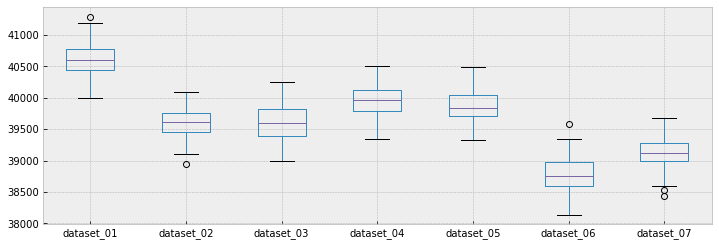

dataset_06    38778.05
dataset_07    39124.55
dataset_02    39601.88
dataset_03    39603.98
dataset_05    39870.51
dataset_04    39960.82
dataset_01    40604.20
dtype: float64


In [31]:
plt.figure(figsize=(12,4))
random_forest_results.boxplot()
plt.show()

print(random_forest_results.mean().sort_values())

In [32]:
print(random_forest_results.mean().mean())

39649.14142857143


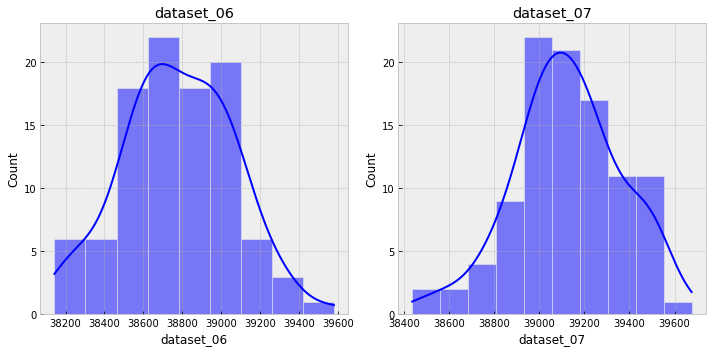

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
best_datasets = random_forest_results.mean().sort_values().index.tolist()[:2]

for ax, name in zip(axes.flatten(), best_datasets):
    sb.histplot(data=random_forest_results[name], kde=True, ax=ax)
    ax.set_title(name)
    
    fig.tight_layout()

In [34]:
a = random_forest_results['dataset_06'].values
b = random_forest_results['dataset_07'].values

print(stats.ttest_rel(a, b))

Ttest_relResult(statistic=-10.422189533549144, pvalue=1.3145408402590313e-17)


### Experiment with CatBoost

In [35]:
TRAIN_SIZE = 0.80

features_list = [
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'comuna', 'neighborhood'], # dataset 01
    ['bedrooms', 'bathrooms', 'total_area_m2', 'comuna', 'neighborhood'], # dataset 02
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'total_area_m2', 'comuna', 'neighborhood'], # dataset 03
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'], # dataset 04
    ['bedrooms', 'bathrooms', 'total_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'], # dataset 05
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'balcony_area', 'comuna', 'neighborhood'], # dataset 06
    ['bedrooms', 'bathrooms', 'total_area_m2', 'balcony_area', 'comuna', 'neighborhood'] # dataset 07
]

# Create empty dataframe
catboost_results = pd.DataFrame()

for idx, features in enumerate(features_list):
    # Define features and target
    X = df[features]
    y = df['price']
    
    # Get dummy variables
    X = pd.get_dummies(X)
    
    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=TRAIN_SIZE, 
                                                        random_state=21)
    
    # 
    scores = []
    for num in range(100):
        SEED = num
        estimator = CatBoostRegressor(random_seed=SEED, 
                                      silent=True)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        score = int(median_absolute_error(y_test, y_pred))
        scores.append(score)
    
    catboost_results['dataset_0{}'.format(idx + 1)] = scores

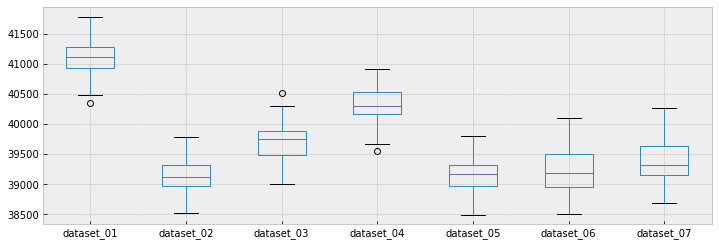

dataset_02    39140.50
dataset_05    39152.91
dataset_06    39213.51
dataset_07    39390.81
dataset_03    39713.52
dataset_04    40336.81
dataset_01    41094.33
dtype: float64


In [36]:
plt.figure(figsize=(12,4))
catboost_results.boxplot()
plt.show()

print(catboost_results.mean().sort_values())

In [37]:
print(catboost_results.mean().mean())

39720.34142857143


In [38]:
print(catboost_results.min().sort_values())

dataset_05    38499
dataset_06    38501
dataset_02    38524
dataset_07    38692
dataset_03    39002
dataset_04    39549
dataset_01    40349
dtype: int64


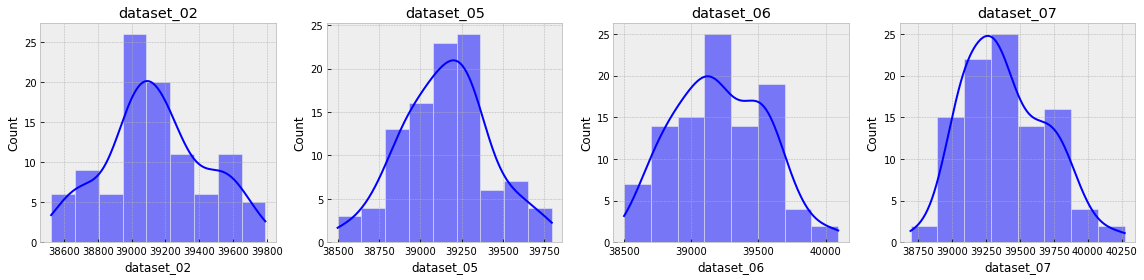

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
best_datasets = catboost_results.mean().sort_values().index.tolist()[:4]

for ax, name in zip(axes.flatten(), best_datasets):
    sb.histplot(data=catboost_results[name], kde=True, ax=ax)
    ax.set_title(name)
    
    fig.tight_layout()

In [40]:
a = catboost_results['dataset_02'].values
b = catboost_results['dataset_05'].values

print(stats.ttest_rel(a, b))

Ttest_relResult(statistic=-0.3329404010615218, pvalue=0.7398833013734922)


In [41]:
a = catboost_results['dataset_02'].values
b = catboost_results['dataset_06'].values

print(stats.ttest_rel(a, b))

Ttest_relResult(statistic=-1.5305300336406094, pvalue=0.1290747890920247)


In [42]:
a = catboost_results['dataset_02'].values
b = catboost_results['dataset_07'].values

print(stats.ttest_rel(a, b))

Ttest_relResult(statistic=-5.930151557880404, pvalue=4.445669769129113e-08)


In [43]:
a = catboost_results['dataset_06'].values
b = catboost_results['dataset_07'].values

print(stats.ttest_rel(a, b))

Ttest_relResult(statistic=-3.6972245073437735, pvalue=0.00035778070326130995)
